# Beta-Bernoulli Classification with NGBoost

**Problem**: Binary classification with calibrated uncertainty. Unlike standard
classifiers that output a single probability, the Beta-Bernoulli gives you a
full *distribution over the probability itself* via its Beta(alpha, beta) prior.

**When to use**:
- Medical diagnosis: not just "80% chance of disease" but "somewhere between 60-95%"
- Fraud detection: flag transactions where the model is genuinely uncertain
- A/B testing: quantify uncertainty in conversion rate predictions
- Any binary outcome where knowing *how confident the model is* matters

**How it works**: The predictive probability for class 1 is `alpha / (alpha + beta)`.
When alpha and beta are both large, the model is confident. When they're small,
there's high uncertainty.

This notebook shows the **classification** pattern using `make_distribution`
with `class_prob_exprs` to produce a complete `ClassificationDistn` in one call.

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [2]:
import numpy as np
import sympy as sp
import sympy.stats as symstats
from scipy.special import digamma
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from ngboost import NGBClassifier
from ngboost.distns.sympy_utils import make_distribution

## 1. Define the distribution

The BetaBernoulli uses a Beta(alpha, beta) prior, so the predictive probability
is `p = alpha / (alpha + beta)`. We pass `class_prob_exprs=[1-p, p]` to tell
the factory this is a classification distribution with two classes.

The factory auto-derives the score, gradient, and Fisher Information from the
Bernoulli likelihood, and auto-generates `class_probs()` and `sample()`.
We provide a custom `fit_fn` for the digamma-based MLE initialization.

In [3]:
alpha, beta, y = sp.symbols("alpha beta y")
p = alpha / (alpha + beta)


def beta_bernoulli_fit(Y):
    """Estimate initial alpha, beta from binary data via digamma MLE."""
    p_hat = np.clip(np.mean(Y), 0.01, 0.99)
    a, b = p_hat * 2, (1 - p_hat) * 2
    for _ in range(100):
        ab = a + b
        psi_ab = digamma(ab)
        a = np.clip(a * (np.mean(digamma(Y + a)) - psi_ab) / (digamma(a) - psi_ab + 1e-10), 1e-4, 1e4)
        b = np.clip(b * (np.mean(digamma(1 - Y + b)) - psi_ab) / (digamma(b) - psi_ab + 1e-10), 1e-4, 1e4)
    return np.array([np.log(a), np.log(b)])


BetaBernoulli = make_distribution(
    params=[(alpha, True), (beta, True)],
    y=y,
    sympy_dist=symstats.Bernoulli("Y", p),
    class_prob_exprs=[1 - p, p],
    fit_fn=beta_bernoulli_fit,
    name="BetaBernoulli",
)

print(f"Distribution: {BetaBernoulli}")
print(f"  Base: {BetaBernoulli.__bases__}")
print(f"  Score class: {BetaBernoulli.scores[0]}")
print(f"  Has analytical metric: {'metric' in BetaBernoulli.scores[0].__dict__}")

Distribution: <class 'ngboost.distns.sympy_utils.BetaBernoulli'>
  Base: (<class 'ngboost.distns.distn.ClassificationDistn'>,)
  Score class: <class 'ngboost.distns.sympy_utils.BetaBernoulliLogScore'>
  Has analytical metric: True


That's it — one `make_distribution` call produces a complete `ClassificationDistn`
with `__init__`, `class_probs`, `sample`, `fit`, and the score/gradient/metric all
auto-generated. Compare this to the manual approach that would require ~40 lines
of boilerplate code.

## 2. Load data

We use the breast cancer dataset — a standard binary classification benchmark.

In [4]:
X, Y = load_breast_cancer(return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)

print(f"Train: {len(Y_train)} ({Y_train.mean():.1%} positive)")
print(f"Test:  {len(Y_test)} ({Y_test.mean():.1%} positive)")

Train: 455 (62.9% positive)
Test:  114 (62.3% positive)


## 3. Train NGBClassifier

In [5]:
from sklearn.tree import DecisionTreeRegressor
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_depth=6,
    splitter="best",
    random_state=None,
)
ngb = NGBClassifier(
    Dist=BetaBernoulli,
    n_estimators=1000,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 4. Predictions with uncertainty

The key advantage: not just a probability, but a *distribution* over probabilities.

In [6]:
# Class predictions
Y_pred = ngb.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
print(f"Accuracy: {accuracy:.1%}")

# Predicted probability distributions
dists = ngb.pred_dist(X_test)
probs = dists.class_probs()  # (n_samples, 2) — [P(0), P(1)]

print(f"\nFirst 5 test samples:")
print(f"  alpha:  {dists.alpha[:5].round(3)}")
print(f"  beta:   {dists.beta[:5].round(3)}")
print(f"  P(y=1): {probs[:5, 1].round(4)}")
print(f"  Actual: {Y_test[:5].astype(int)}")

Accuracy: 95.6%

First 5 test samples:
  alpha:  [0.003 0.    0.    0.003 0.003]
  beta:   [0.    0.003 0.003 0.    0.   ]
  P(y=1): [9.991e-01 9.000e-04 9.000e-04 9.991e-01 9.991e-01]
  Actual: [1 0 0 1 1]


## 5. Quantify prediction uncertainty

The Beta distribution over `p` lets us compute confidence intervals.
When alpha and beta are large, the model is confident. When they're
small, there's high uncertainty about the true probability.

In [7]:
import scipy.stats

# Compute 90% credible intervals for P(y=1)
p_lower = scipy.stats.beta.ppf(0.05, dists.alpha, dists.beta)
p_upper = scipy.stats.beta.ppf(0.95, dists.alpha, dists.beta)
p_mean = dists.alpha / (dists.alpha + dists.beta)

# Width of credible interval = uncertainty
uncertainty = p_upper - p_lower

print("90% credible intervals for P(y=1) — first 10 test samples:")
print(f"{'idx':>4s}  {'P(y=1)':>8s}  {'90% CI':>18s}  {'width':>8s}  {'true':>5s}")
for i in range(10):
    print(f"{i:4d}  {p_mean[i]:8.4f}  [{p_lower[i]:.4f}, {p_upper[i]:.4f}]  {uncertainty[i]:8.4f}  {int(Y_test[i]):5d}")

print(f"\nMean uncertainty (CI width): {uncertainty.mean():.4f}")
print(f"Most uncertain sample:  idx={np.argmax(uncertainty)}, width={uncertainty.max():.4f}")
print(f"Most confident sample:  idx={np.argmin(uncertainty)}, width={uncertainty.min():.4f}")

90% credible intervals for P(y=1) — first 10 test samples:
 idx    P(y=1)              90% CI     width   true
   0    0.9991  [1.0000, 1.0000]    0.0000      1
   1    0.0009  [0.0000, 0.0000]    0.0000      0
   2    0.0009  [0.0000, 0.0000]    0.0000      0
   3    0.9991  [1.0000, 1.0000]    0.0000      1
   4    0.9991  [1.0000, 1.0000]    0.0000      1
   5    0.0009  [0.0000, 0.0000]    0.0000      0
   6    0.0009  [0.0000, 0.0000]    0.0000      0
   7    0.0011  [0.0000, 0.0000]    0.0000      0
   8    0.0020  [0.0000, 0.0000]    0.0000      1
   9    0.9968  [1.0000, 1.0000]    0.0000      1

Mean uncertainty (CI width): 0.0088
Most uncertain sample:  idx=13, width=1.0000
Most confident sample:  idx=0, width=0.0000


## 6. Visualize

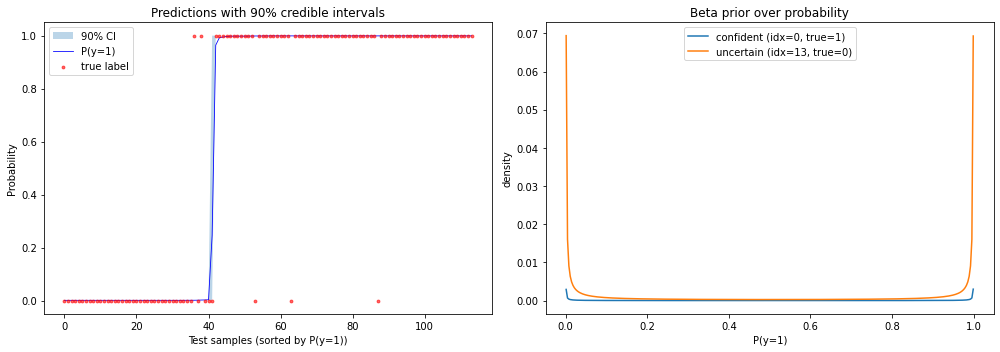

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: predicted probabilities with credible intervals, sorted by predicted P(y=1)
ax = axes[0]
order = np.argsort(p_mean)
x = np.arange(len(order))
ax.fill_between(x, p_lower[order], p_upper[order], alpha=0.3, label="90% CI")
ax.plot(x, p_mean[order], "b-", linewidth=0.8, label="P(y=1)")
ax.scatter(x, Y_test[order], c="red", s=8, alpha=0.6, zorder=5, label="true label")
ax.set_xlabel("Test samples (sorted by P(y=1))")
ax.set_ylabel("Probability")
ax.set_title("Predictions with 90% credible intervals")
ax.legend()

# Right: Beta distributions for a confident vs uncertain prediction
ax = axes[1]
p_grid = np.linspace(0.001, 0.999, 300)

# Most confident
i_conf = np.argmin(uncertainty)
pdf_conf = scipy.stats.beta.pdf(p_grid, dists.alpha[i_conf], dists.beta[i_conf])
ax.plot(p_grid, pdf_conf,
        label=f"confident (idx={i_conf}, true={int(Y_test[i_conf])})")

# Most uncertain
i_unc = np.argmax(uncertainty)
pdf_unc = scipy.stats.beta.pdf(p_grid, dists.alpha[i_unc], dists.beta[i_unc])
ax.plot(p_grid, pdf_unc,
        label=f"uncertain (idx={i_unc}, true={int(Y_test[i_unc])})")

ax.set_xlabel("P(y=1)")
ax.set_ylabel("density")
ax.set_title("Beta prior over probability")
ax.legend()

plt.tight_layout()
plt.show()

## Note: the `class_prob_exprs` pattern

The key to classification with `make_distribution` is the `class_prob_exprs`
parameter — a list of SymPy expressions `[P(Y=0), P(Y=1), ...]` that define
class probabilities as functions of the distribution parameters. When provided:

- The factory produces a `ClassificationDistn` (not `RegressionDistn`)
- `class_probs()` is auto-generated by lambdifying the expressions
- `sample()` draws categorical samples from those probabilities
- Everything else (`__init__`, `fit`, score, gradient, FI) works the same

This pattern supports any number of classes. For K-class classification,
provide K expressions that sum to 1.